In [2]:
from PIL import Image
import requests
import time
%matplotlib widget
import matplotlib.pyplot as plt
from IPython.display import clear_output
import ipywidgets as widgets
from IPython.display import display
import asyncio

err_max_len = 30

In [3]:
addresses = ['106.109.164.81:8000', '106.109.164.29:8000', '127.0.0.1:8000']

In [4]:
def stop():
    stopped = 0
    for address in addresses:
        try:
            response = requests.get(f'http://{address}/stop')
            stopped+=1
            print(f'stopped {address}')
        except Exception as e:
            print(f'unable to stop {address}: {str(e)[:err_max_len]}')
    if (stopped != len(addresses)):
        print('error')

def start(fisheye=False):
    fname = time.strftime("%Y-%m-%d-%H-%M-%S")
    started = 0
    for address in addresses:
        try:
            response = requests.get(f"http://{address}/start?fname={fname}&fish={'on' if fisheye else 'off'}")
            started+=1
            print(f'started {address}')
        except Exception as e:
            print(f'unable to start {address}: {str(e)[:err_max_len]}')
    if (started != len(addresses)): 
        print('error, stopping all')
        stop()
        
def show_preview(ip):
    response = requests.get(f'http://{ip}/preview', stream=True)
    img = Image.open(response.raw)
    plt.imshow(img)
    plt.show()

def monitor():
    try:
        while True:
            clear_output(wait=True)
            for address in addresses:
                try: show_preview(address)
                except Exception as e:
                    print(f'{address}: no image; {str(e)[:err_max_len]}')
            time.sleep(2)
    except KeyboardInterrupt:
        print('exit')

ToggleButton(value=False, description='Start')

Checkbox(value=False, description='calibration')

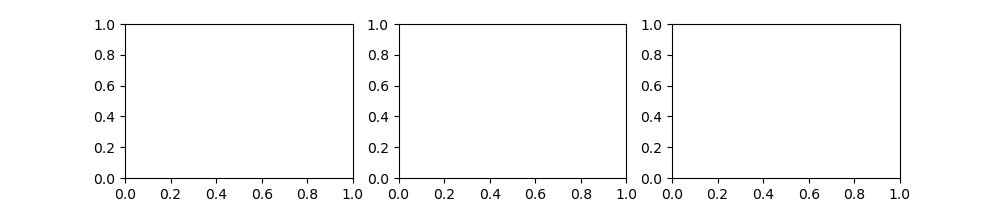

In [9]:
start_button = widgets.ToggleButton(value=False, description='Start')
calib_checkbox = widgets.Checkbox(value=False, description='calibration')
output = widgets.Output()

display(start_button)
display(calib_checkbox)

fig = plt.figure(figsize=(10, 2))
a1 = fig.add_subplot(131)
a2 = fig.add_subplot(132)
fe = fig.add_subplot(133)

class RecorderClient:

    def __init__(self, s_btn, f_chb, img_dspl):
        self.s_btn = s_btn
        self.f_chb = f_chb
        self.img_dspl = img_dspl
        self.state = False

    async def run(self):
        while True:
            if self.s_btn.value != self.state:
                if self.s_btn.value:
                    self.s_btn.description = 'Stop'
                    with output: start(fisheye=self.f_chb.value)
                else:
                    self.s_btn.description = 'Start'
                    with output: stop()
                self.state = self.s_btn.value
            await asyncio.sleep(2)
            if (self.state): 
                for i, address in enumerate(addresses):
                    try: 
                        response = requests.get(f'http://{address}/preview', stream=True)
                        img = Image.open(response.raw)
                        self.img_dspl[i].imshow(img)
                    except Exception as e:
                        with output: print(f'{address}: no image; {str(e)[:err_max_len]}')
            
    def start(self):
        asyncio.ensure_future(self.run())

RecorderClient(start_button, calib_checkbox, [a1, a2, fe]).start()

### Raw interface

In [5]:
start(fisheye=False)

started 106.109.164.81:8000
started 106.109.164.29:8000
started 127.0.0.1:8000


In [6]:
monitor()

106.109.164.81:8000: no image; cannot identify image file <_i
exit


In [7]:
stop()

stopped 106.109.164.81:8000
stopped 106.109.164.29:8000
stopped 127.0.0.1:8000
